<a href="https://colab.research.google.com/github/ashia-002/Fake-News-Detection-Bilingual-Multimodel/blob/main/CNN_Pipeline/image_Clasification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

/tmp/ipython-input-2896494265.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## 1. Setting the path

In [3]:
# New line for Google Colab:
main_dir = r"/content/drive/MyDrive/CNN/data" # Adjust 'newsDataset' if you uploaded a different folder

In [4]:
import os
os.listdir(main_dir)

['fake', 'real']

In [5]:
for folder_name in os.listdir(main_dir):
    # 1. Get the full path to the subfolder ('/path/to/your/main_dir/fake')
    path_to_subfolder = os.path.join(main_dir, folder_name)

    # 2. Get the full path to the images ('/path/to/your/main_dir/fake/BN')
    for folder in os.listdir(path_to_subfolder):
      img_path = os.path.join(path_to_subfolder, folder)


In [7]:
#/content/drive/MyDrive/CNN/data/fake/BN/-1RWCMzPMOg.jpg
img = cv2.imread(os.path.join(main_dir, 'fake', 'BN', '-1RWCMzPMOg.jpg'))

In [8]:
type(img) #numpy array


numpy.ndarray

In [9]:
img.shape #rgb channel

(720, 1280, 3)

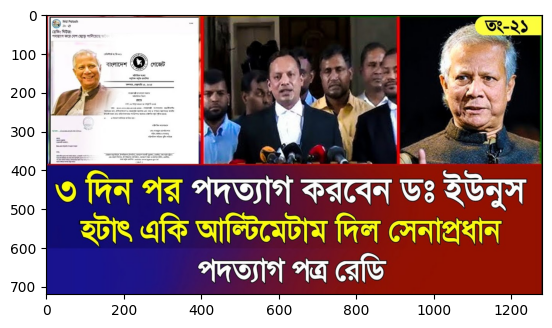

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 2. loading Image

In [11]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [12]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

### 2.1. removing empty image

In [13]:
for folder_name in os.listdir(main_dir):
    # 1. Get the full path to the subfolder ('/path/to/your/main_dir/fake')
    path_to_subfolder = os.path.join(main_dir, folder_name)

    # 2. Get the full path to the images ('/path/to/your/main_dir/fake/BN')
    for folder in os.listdir(path_to_subfolder):
      img_path = os.path.join(path_to_subfolder, folder)

      try:
        img = cv2.imread(img_path)
        tip = imghdr.what(img_path)
        if tip not in image_exts:
          print('Image not in ext list{}'.format(img_path))
          os.remove(img_path)
      except Exception as e:
        print('Issue with image {}'.format(img_path))



Issue with image /content/drive/MyDrive/CNN/data/fake/EN
Issue with image /content/drive/MyDrive/CNN/data/fake/BN
Issue with image /content/drive/MyDrive/CNN/data/real/EN
Issue with image /content/drive/MyDrive/CNN/data/real/BN


### 2.2. load data in tensorflow

In [14]:
import tensorflow as tf

In [15]:
# for building data pipeline
tf.data.Dataset??

In [16]:
tf.keras.utils.image_dataset_from_directory??

In [17]:
data = tf.keras.utils.image_dataset_from_directory(main_dir)

Found 4000 files belonging to 2 classes.


In [18]:
'''A Python iterator allows you to use standard Python flow control,
primarily the next() function or a for loop, to sequentially pull data batches.'''
data_iterator = data.as_numpy_iterator() #allowing to loop through the whole pipelne

In [19]:
batch = data_iterator.next() # grabing the batch each time

In [20]:
len(batch) # two parts: image from the directory(batch[0]), label(batch[1])

2

In [21]:
# represented as numpy arrays
batch[0].shape #the pipeline automatically reshaped the image

(32, 256, 256, 3)

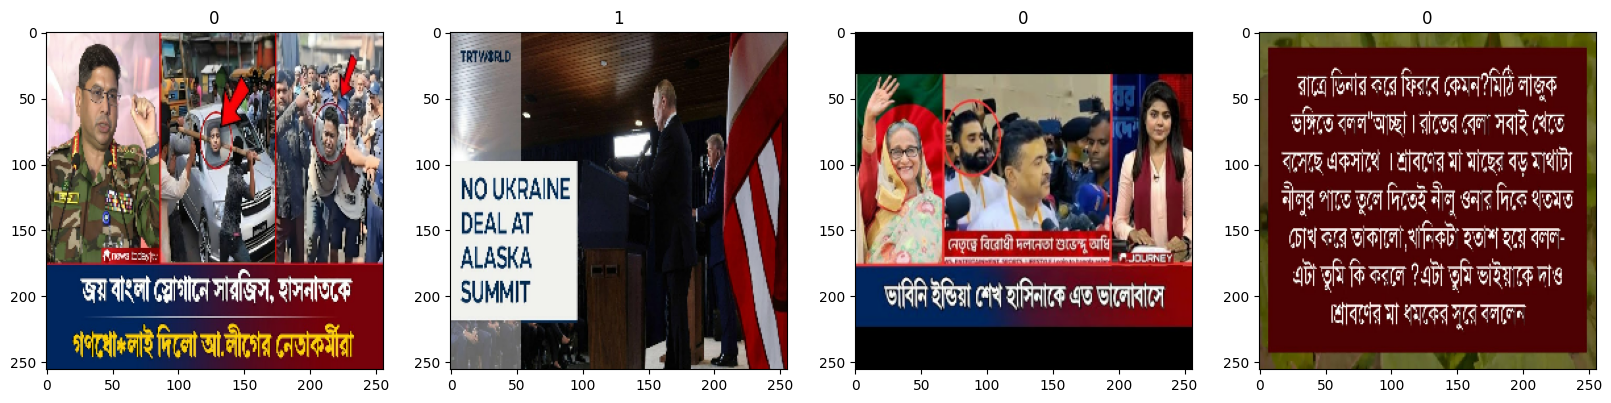

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx]) #fake = 0, real = 1

## 3. Preprocess data

In [23]:
batch[0].max()

np.float32(255.0)

In [24]:
batch[0].min()

np.float32(0.0)

### 3.1. Normalization$\text{Value} / 255$

In [25]:
data = data.map(lambda x,y: (x/255, y)) #in pipeline mapping each batch and normalizing where x=batch[0]

In [26]:
# now looking at a batch
batch = data.as_numpy_iterator().next()

In [27]:
batch[0].min()

np.float32(0.0)

In [28]:
batch[0].max()

np.float32(1.0)

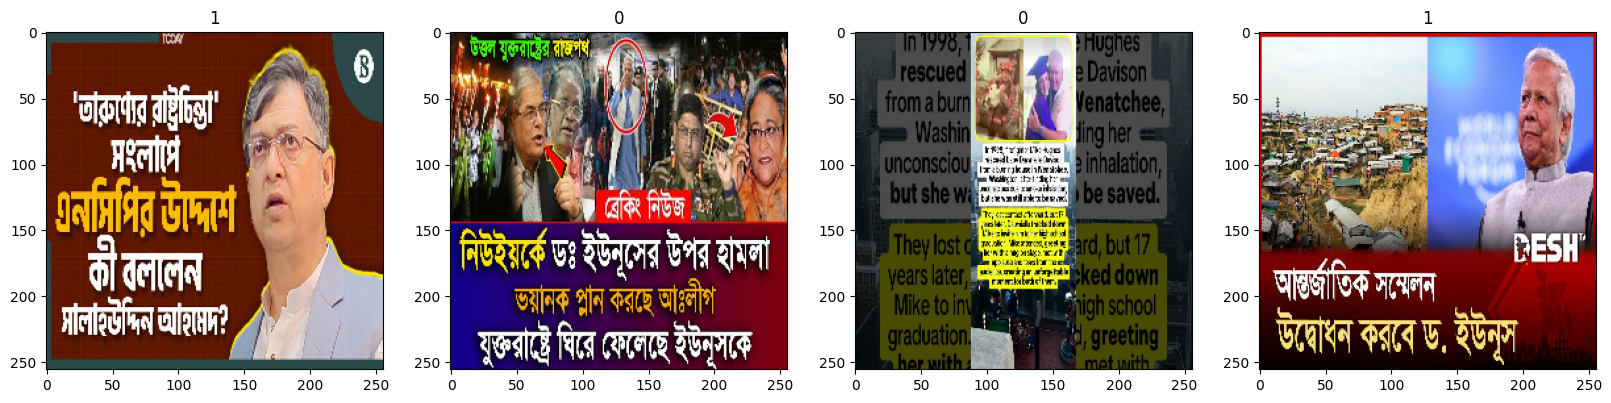

In [29]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(float)) #now it's not int anymore
  ax[idx].title.set_text(batch[1][idx]) #fake = 0, real = 1

### 3.2. Split the data

In [30]:
len(data) # total 125 batches(125x32=4000)

125

In [31]:
# Calculate 70% of the total number of batches/elements in the dataset for training.
train_size = int(len(data) * 0.7)
# Calculate 20% for validation, and add 1 to ensure all data is accounted for when using integer math.
val_size = int(len(data) * 0.2) + 1
# Calculate 10% for testing, and add 1 to ensure all data is accounted for when using integer math.
test_size = int(len(data) * 0.1) + 1

In [32]:
val_size

26

In [33]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [34]:
#Final Optimization (Cache and Prefetch) ---
AUTOTUNE = tf.data.AUTOTUNE
# Shuffle the ENTIRE Dataset FIRST ---
# This ensures a random distribution across the resulting splits.
BUFFER_SIZE = 1000  # A good buffer size for effective shuffling
data = data.shuffle(buffer_size=BUFFER_SIZE)

In [35]:
# Apply cache and prefetch to ALL datasets
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipeline successfully implemented:")
print(f"   - Full dataset was shuffled before splitting.")
print(f"   - Split sizes: Train ({train_size}), Val ({val_size}), Test ({len(test)})")
print(f"   - All datasets are optimized with .cache() and .prefetch().")

Data pipeline successfully implemented:
   - Full dataset was shuffled before splitting.
   - Split sizes: Train (87), Val (26), Test (12)
   - All datasets are optimized with .cache() and .prefetch().


## 4. Build Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
model = Sequential()

In [38]:
# Block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# --- Classification Head ---

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,467,073 (28.48 MB)

 Trainable params: 7,466,625 (28.48 MB)

 Non-trainable params: 448 (1.75 KB)

### 4.1 Train the model

In [41]:
log_dir = r"/content/drive/MyDrive/CNN/logs"

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [43]:
# Setup Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',         # Stop when validation loss stops improving
    patience=8,                # Wait 8 epochs for improvement
    restore_best_weights=True   # Keep the best weights found
)

In [44]:
hist = model.fit(train,
                 epochs=20,
                 validation_data=val,
                 callbacks=[tensorboard_callback, early_stopping] )

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 763s 9s/step - accuracy: 0.8399 - loss: 1.9025 - val_accuracy: 0.4904 - val_loss: 26.4076
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 651s 7s/step - accuracy: 0.9127 - loss: 0.3752 - val_accuracy: 0.4904 - val_loss: 7.3149
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 650s 7s/step - accuracy: 0.9470 - loss: 0.2129 - val_accuracy: 0.4976 - val_loss: 21.6021
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 653s 8s/step - accuracy: 0.9424 - loss: 0.2400 - val_accuracy: 0.4904 - val_loss: 28.6071
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 648s 7s/step - accuracy: 0.9395 - loss: 0.2782 - val_accuracy: 0.5685 - val_loss: 7.2648
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 685s 8s/step - accuracy: 0.9295 - loss: 0.1615 - val_accuracy: 0.7091 - val_loss: 7.8870
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 646s 7s/step - accuracy: 0.9494 - loss: 0.2407 - val_accuracy: 0.9579 - val_loss: 0.1109
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 649s 7s/step - accuracy: 0.9489 - loss: 0.2613 - val_accuracy: 0.9688 

### 4.2. Plot Performance

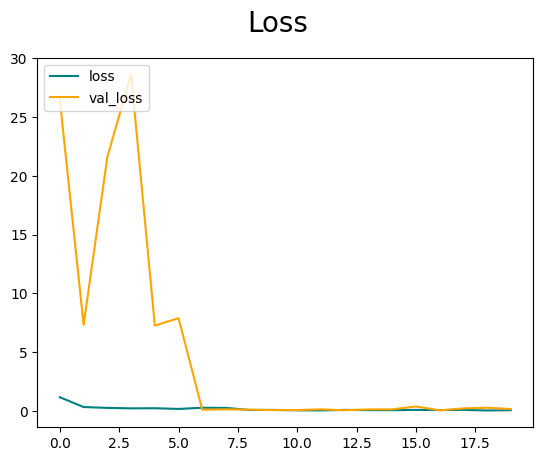

In [78]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4.3. Evaluate the model

In [53]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [54]:
for batch in test.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [55]:
print(f'Precision: {pre.result()}, Result: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9707317352294922, Result: 1.0, Accuracy: 0.984375


In [56]:
# Assuming 'model' has the best weights restored, and 'test' is your optimized test dataset

print("Evaluating final model performance on the test set...")

# Run the evaluation
test_results = model.evaluate(test)

# Print the results
print("\n--- Test Set Evaluation Results ---")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]*100:.2f}%")

Evaluating final model performance on the test set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9847 - loss: 0.0220

--- Test Set Evaluation Results ---
Test Loss: 0.0275
Test Accuracy: 98.44%


## 5. Test Model

Saving oxbFM-jEHa4.jpg to oxbFM-jEHa4 (3).jpg
Saving Qd6m4sGxsl4.jpg to Qd6m4sGxsl4 (3).jpg
Saving oW6493zWmFY.jpg to oW6493zWmFY (3).jpg
Saving OXmHELRQSQk.jpg to OXmHELRQSQk (3).jpg
Saving _7TwygXPo9E.jpg to _7TwygXPo9E (3).jpg
Saving D50B6mIMOrw.jpg to D50B6mIMOrw (3).jpg
Saving 2cEjKZhhdOs.jpg to 2cEjKZhhdOs (3).jpg
Saving ac5sgSSVCYU.jpg to ac5sgSSVCYU (3).jpg
Saving 0x_Z8hRthdk.jpg to 0x_Z8hRthdk (3).jpg
Saving 3p7FWTnWS1Y.jpg to 3p7FWTnWS1Y (3).jpg
Saving 4Z5aa9HV4aw.jpg to 4Z5aa9HV4aw (3).jpg
Saving _XZsUGMNGW8.jpg to _XZsUGMNGW8 (3).jpg
Saving 560632496_1214235780747365_8005057533123582614_n.jpg to 560632496_1214235780747365_8005057533123582614_n (3).jpg
Saving 0uWF9WpUoUs.jpg to 0uWF9WpUoUs (3).jpg
Saving 1cV2QfWohvQ.jpg to 1cV2QfWohvQ (3).jpg
Saving 0-gFRqUjaS0.jpg to 0-gFRqUjaS0 (3).jpg
Saving _Bpg2rIZfk0.jpg to _Bpg2rIZfk0 (3).jpg
Saving oW6493zWmFY - Copy.jpg to oW6493zWmFY - Copy.jpg

--- Processing Image: oxbFM-jEHa4 (3).jpg ---
Model Prediction: **FAKE** (Confidence: 1

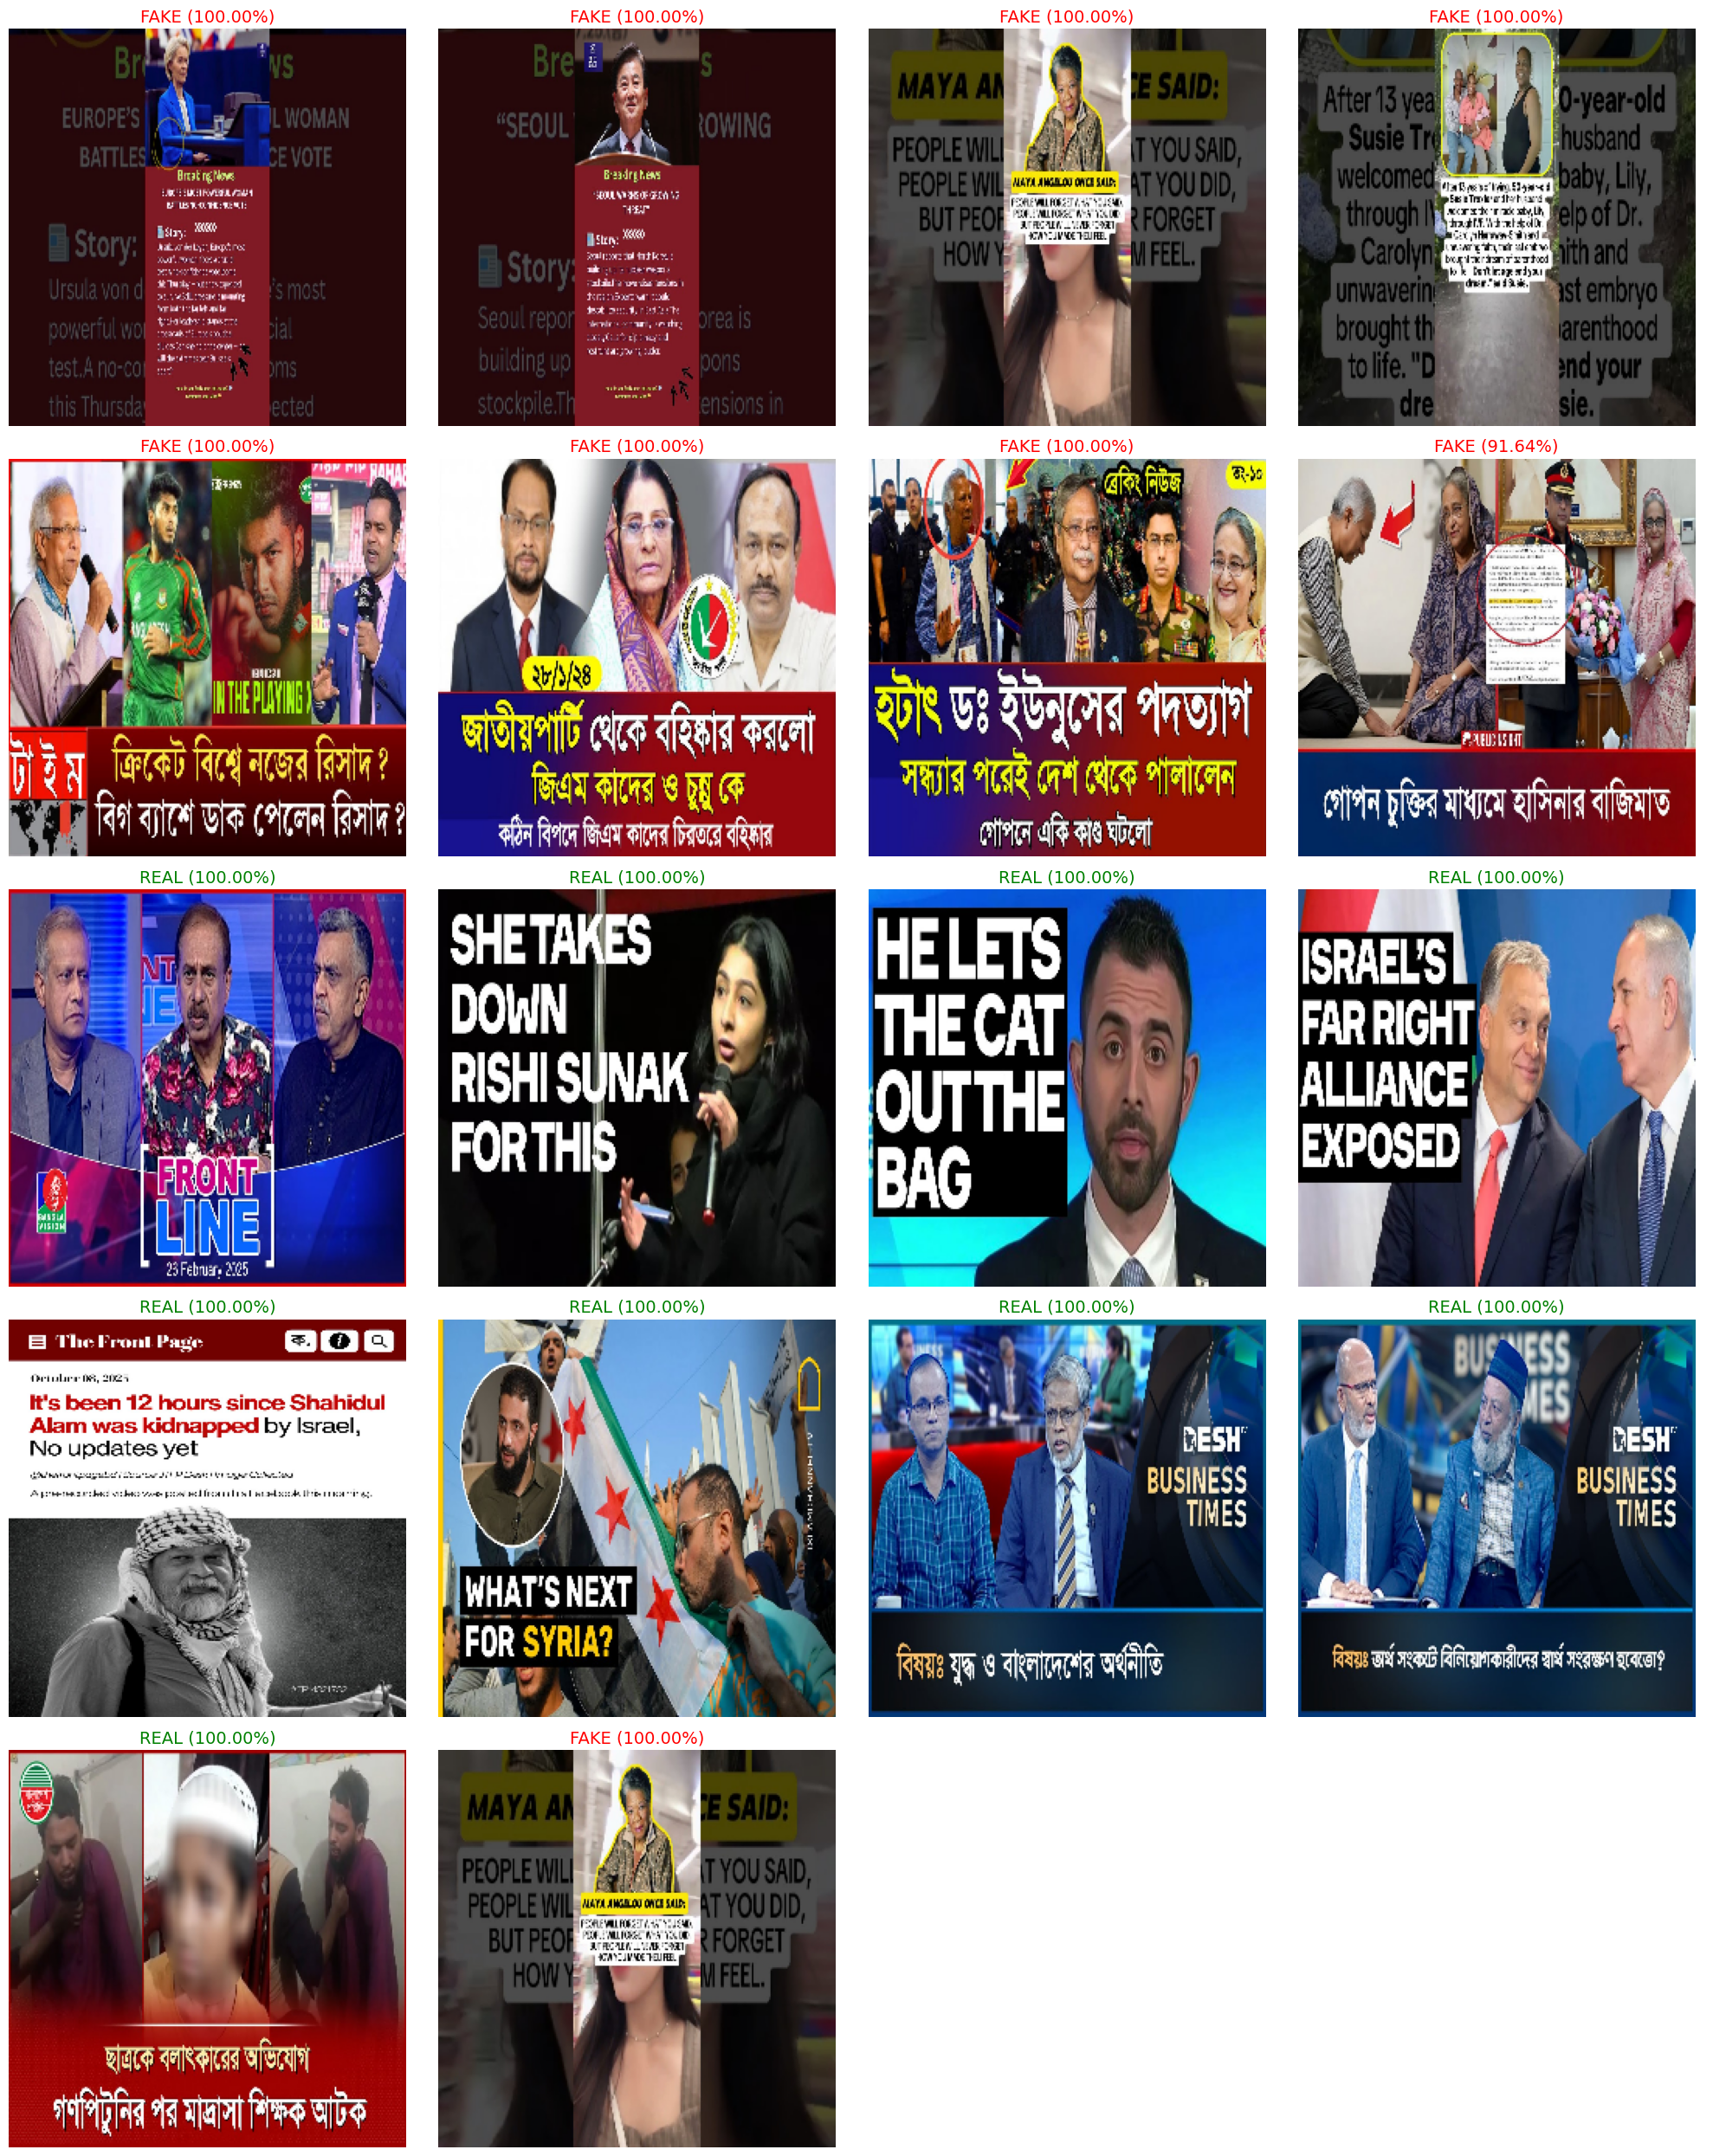

In [77]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from google.colab import files

# --- 1. Upload Files ---
uploaded = files.upload()

IMAGE_SIZE = (256, 256)
NUM_COLS = 4
num_images = len(uploaded)
# Calculate the number of rows needed for the 4-column layout
NUM_ROWS = (num_images + NUM_COLS - 1) // NUM_COLS

# Create the figure for the grid of subplots
fig, ax = plt.subplots(ncols=NUM_COLS, nrows=NUM_ROWS, figsize=(5 * NUM_COLS, 5 * NUM_ROWS))
i = 0 # Initialize a counter for flat indexing (0 to num_images - 1)

# Ensure 'ax' is a 1D array for simpler indexing, even if NUM_ROWS is 1
ax_flat = ax.flatten() if isinstance(ax, np.ndarray) else np.array([ax])

# Iterate through every filename uploaded
for filename in uploaded.keys():

    print(f"\n--- Processing Image: {filename} ---")

    # 2. Load and Convert Image (BGR -> RGB)
    img_bgr = cv2.imread(filename)

    if img_bgr is None:
        print(f"Error: Could not load image file '{filename}'. Skipping.")
        continue

    rgb_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 3. Preprocess for Model Prediction
    resize_tensor = tf.image.resize(rgb_img, IMAGE_SIZE)
    img_array = resize_tensor.numpy()

    # Normalize and add batch dimension
    input_tensor = img_array.astype(np.float32) / 255.0
    input_tensor = tf.expand_dims(input_tensor, 0)

    # 4. Make the Prediction
    prediction = model.predict(input_tensor, verbose=0) # Set verbose=0 to silence output
    probability = prediction[0][0]

    # 5. Interpret the Result
    if probability > 0.5:
        result = "REAL"
        confidence = probability * 100
        color = 'green'
    else:
        result = "FAKE"
        confidence = (1 - probability) * 100
        color = 'red'

    # 6. Display in Subplot with Prediction Title

    # Use the flattened axis array for indexing
    current_ax = ax_flat[i]

    # Plot the image
    current_ax.imshow(img_array.astype('uint8'))

    # Create the title with prediction and confidence
    title_text = f"{result} ({confidence:.2f}%)"
    current_ax.set_title(title_text, fontsize=14, color=color)
    current_ax.axis('off') # Hide axes

    # print(f"Model Prediction: **{result}** (Confidence: {confidence:.2f}%)")
    i += 1

# Hide any empty subplots in the last row if the total number of images wasn't a multiple of 4
for j in range(i, len(ax_flat)):
    ax_flat[j].axis('off')

plt.tight_layout()
plt.show()